In [1]:
import os
files = os.listdir()
print(files)

['.config', 'sample_data']


In [2]:
import zipfile
zip_file_path = 'Museum_Training.zip'
extraction_path = 'Museum_Training1'

zip_file_path2 = 'Museum_Test.zip'
extraction_path2 = 'Museum_Test1'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

with zipfile.ZipFile(zip_file_path2, 'r') as zip_ref:
    zip_ref.extractall(extraction_path2)


In [3]:
import os
files = os.listdir()
print(files)

['.config', 'Museum_Training.zip', 'Museum_Test.zip', 'Museum_Training1', 'Museum_Test1', 'sample_data']


In [4]:
def list_subdirectories(directory):
    subdirectories = [f for f in os.listdir(directory) if os.path.isdir(os.path.join(directory, f))]
    return subdirectories

root_directory = 'Museum_Training1'
subdirs = list_subdirectories(root_directory)
print(subdirs)

toot_directory2 = 'Museum_Test1'
subdirs2 = list_subdirectories(toot_directory2)
print(subdirs2)

['Training']
['Museum_Validation']


In [5]:
# Data Preparation
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import os
from PIL import Image
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

class MuseumDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.classes = ['museum-indoor', 'museum-outdoor']
        self.image_paths = []
        self.labels = []

        for class_idx, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(class_dir, img_name))
                    self.labels.append(class_idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

full_train_dataset = MuseumDataset(
    root_dir='Museum_Training1/Training',
    transform=train_transform
)

train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(
    full_train_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# Loading original test set
test_dataset = MuseumDataset(
    root_dir='Museum_Test1/Museum_Validation',
    transform=test_transform
)

# Verifying the splits
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 8000
Validation samples: 2000
Test samples: 200


In [6]:
# Testing for GPU
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
Tesla T4


In [7]:
# CNN architecture

class MuseumCNN(nn.Module):
    def __init__(self, num_conv_layers=3, dropout_rate=0.5):
        super().__init__()
        layers = []
        in_channels = 3

        # Dynamic convolutional layers
        for i in range(num_conv_layers):
            out_channels = 32 * (2**i)
            layers += [
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
                nn.MaxPool2d(2)
            ]
            in_channels = out_channels

        self.features = nn.Sequential(*layers)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))
        self.classifier = nn.Sequential(
            nn.Linear(in_channels * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [13]:
# Hyperparameter Tuning
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def tune_hyperparameters():
    param_grid = {
        'num_conv_layers': [2, 3],
        'dropout_rate': [0.3, 0.5],
        'lr': [0.01, 0.001],
        'batch_size': [64, 128]
    }

    best_acc = 0
    best_params = {}
    history = []

    for n_layers in param_grid['num_conv_layers']:
        for dropout in param_grid['dropout_rate']:
            for lr in param_grid['lr']:
                for bs in param_grid['batch_size']:
                    print(f"\nTesting: layers={n_layers}, dropout={dropout}, lr={lr}, bs={bs}")

                    model = MuseumCNN(n_layers, dropout).to(device)
                    optimizer = optim.Adam(model.parameters(), lr=lr)
                    criterion = nn.CrossEntropyLoss()
                    train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
                    val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=False)

                    for epoch in range(2):
                        model.train()
                        train_loss, train_correct, total = 0.0, 0, 0
                        for images, labels in train_loader:
                            images, labels = images.to(device), labels.to(device)
                            optimizer.zero_grad()
                            outputs = model(images)
                            loss = nn.CrossEntropyLoss()(outputs, labels)
                            loss.backward()
                            optimizer.step()
                            train_loss += loss.item()
                            _, predicted = torch.max(outputs.data, 1)
                            total += labels.size(0)
                            train_correct += (predicted == labels).sum().item()

                        model.eval()
                        val_correct, val_total = 0, 0
                        with torch.no_grad():
                            for images, labels in val_loader:
                                images, labels = images.to(device), labels.to(device)
                                outputs = model(images)
                                _, predicted = torch.max(outputs.data, 1)
                                val_total += labels.size(0)
                                val_correct += (predicted == labels).sum().item()

                        train_acc = train_correct / total
                        val_acc = val_correct / val_total

                        print(f"Epoch {epoch+1}: "
                              f"Train Loss: {train_loss/len(train_loader):.4f} | "
                              f"Train Acc: {train_acc:.4f} | "
                              f"Val Acc: {val_acc:.4f}")

                    if val_acc > best_acc:
                        best_acc = val_acc
                        best_params = {
                            'num_conv_layers': n_layers,
                            'dropout_rate': dropout,
                            'lr': lr,
                            'batch_size': bs
                        }
                        print(f"New best val_acc: {val_acc:.4f}")

    print("\nBest parameters:", best_params)
    return best_params

best_params = tune_hyperparameters()


Testing: layers=2, dropout=0.3, lr=0.01, bs=64
Epoch 1: Train Loss: 0.6710 | Train Acc: 0.8436 | Val Acc: 0.8535
Epoch 2: Train Loss: 0.3090 | Train Acc: 0.8826 | Val Acc: 0.8605
New best val_acc: 0.8605

Testing: layers=2, dropout=0.3, lr=0.01, bs=128
Epoch 1: Train Loss: 0.9237 | Train Acc: 0.8114 | Val Acc: 0.8600
Epoch 2: Train Loss: 0.3069 | Train Acc: 0.8828 | Val Acc: 0.8810
New best val_acc: 0.8810

Testing: layers=2, dropout=0.3, lr=0.001, bs=64
Epoch 1: Train Loss: 0.3417 | Train Acc: 0.8572 | Val Acc: 0.8755
Epoch 2: Train Loss: 0.2797 | Train Acc: 0.8928 | Val Acc: 0.8920
New best val_acc: 0.8920

Testing: layers=2, dropout=0.3, lr=0.001, bs=128
Epoch 1: Train Loss: 0.3613 | Train Acc: 0.8442 | Val Acc: 0.8740
Epoch 2: Train Loss: 0.2835 | Train Acc: 0.8929 | Val Acc: 0.8900

Testing: layers=2, dropout=0.5, lr=0.01, bs=64
Epoch 1: Train Loss: 0.7393 | Train Acc: 0.8341 | Val Acc: 0.8710
Epoch 2: Train Loss: 0.3202 | Train Acc: 0.8814 | Val Acc: 0.8725

Testing: layers=2, d

In [15]:
# Initialize with best params
model = MuseumCNN(
    num_conv_layers=best_params['num_conv_layers'],
    dropout_rate=best_params['dropout_rate']
).to(device)

optimizer = optim.Adam(model.parameters(), lr=best_params['lr'])
train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True,pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False,pin_memory=True)

# Training loop
def train_model(model, train_loader, val_loader, optimizer, epochs=15):
    criterion = nn.CrossEntropyLoss()
    best_val_acc = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}'):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad(set_to_none=True)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = correct / total
        train_loss = running_loss / len(train_loader)

        # Validation
        val_loss, val_acc = validate(model, val_loader, criterion)

        print(f"Results:")
        print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'hyperparameters': best_params,
                'val_accuracy': val_acc,
                'epoch': epoch
            }, 'best_cnn_model_full.pth')
            print(f"New best model saved (val_acc: {val_acc:.4f})\n")

    return model

def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return running_loss/len(loader), correct/total

# Start training
trained_model = train_model(model, train_loader, val_loader, optimizer)

Epoch 1: 100%|██████████| 125/125 [00:21<00:00,  5.94it/s]


Results:
Train Loss: 0.3608 | Acc: 0.8534
Val Loss: 0.3082 | Acc: 0.8835
New best model saved (val_acc: 0.8835)



Epoch 2: 100%|██████████| 125/125 [00:21<00:00,  5.95it/s]


Results:
Train Loss: 0.2718 | Acc: 0.8968
Val Loss: 0.2957 | Acc: 0.8845
New best model saved (val_acc: 0.8845)



Epoch 3: 100%|██████████| 125/125 [00:21<00:00,  5.83it/s]


Results:
Train Loss: 0.2459 | Acc: 0.9067
Val Loss: 0.3015 | Acc: 0.8970
New best model saved (val_acc: 0.8970)



Epoch 4: 100%|██████████| 125/125 [00:21<00:00,  5.78it/s]


Results:
Train Loss: 0.2390 | Acc: 0.9096
Val Loss: 0.2649 | Acc: 0.9015
New best model saved (val_acc: 0.9015)



Epoch 5: 100%|██████████| 125/125 [00:21<00:00,  5.81it/s]


Results:
Train Loss: 0.2249 | Acc: 0.9171
Val Loss: 0.2556 | Acc: 0.9070
New best model saved (val_acc: 0.9070)



Epoch 6: 100%|██████████| 125/125 [00:21<00:00,  5.74it/s]


Results:
Train Loss: 0.2143 | Acc: 0.9223
Val Loss: 0.2330 | Acc: 0.9135
New best model saved (val_acc: 0.9135)



Epoch 7: 100%|██████████| 125/125 [00:21<00:00,  5.80it/s]


Results:
Train Loss: 0.2042 | Acc: 0.9279
Val Loss: 0.2270 | Acc: 0.9215
New best model saved (val_acc: 0.9215)



Epoch 8: 100%|██████████| 125/125 [00:21<00:00,  5.79it/s]


Results:
Train Loss: 0.1982 | Acc: 0.9266
Val Loss: 0.2327 | Acc: 0.9125


Epoch 9: 100%|██████████| 125/125 [00:20<00:00,  6.06it/s]


Results:
Train Loss: 0.1898 | Acc: 0.9294
Val Loss: 0.2197 | Acc: 0.9160


Epoch 10: 100%|██████████| 125/125 [00:20<00:00,  6.02it/s]


Results:
Train Loss: 0.1809 | Acc: 0.9307
Val Loss: 0.2219 | Acc: 0.9215


Epoch 11: 100%|██████████| 125/125 [00:21<00:00,  5.90it/s]


Results:
Train Loss: 0.1827 | Acc: 0.9334
Val Loss: 0.2154 | Acc: 0.9165


Epoch 12: 100%|██████████| 125/125 [00:21<00:00,  5.87it/s]


Results:
Train Loss: 0.1806 | Acc: 0.9326
Val Loss: 0.2418 | Acc: 0.9170


Epoch 13: 100%|██████████| 125/125 [00:21<00:00,  5.81it/s]


Results:
Train Loss: 0.1674 | Acc: 0.9374
Val Loss: 0.2266 | Acc: 0.9155


Epoch 14: 100%|██████████| 125/125 [00:21<00:00,  5.76it/s]


Results:
Train Loss: 0.1672 | Acc: 0.9375
Val Loss: 0.2025 | Acc: 0.9280
New best model saved (val_acc: 0.9280)



Epoch 15: 100%|██████████| 125/125 [00:21<00:00,  5.71it/s]


Results:
Train Loss: 0.1614 | Acc: 0.9440
Val Loss: 0.2139 | Acc: 0.9275


Accuracy: 0.9300
Precision: 0.9302
Recall: 0.9300
F1-score: 0.9300
              precision  recall  f1-score  support
Indoor         0.921569    0.94  0.930693   100.00
Outdoor        0.938776    0.92  0.929293   100.00
accuracy       0.930000    0.93  0.930000     0.93
macro avg      0.930172    0.93  0.929993   200.00
weighted avg   0.930172    0.93  0.929993   200.00


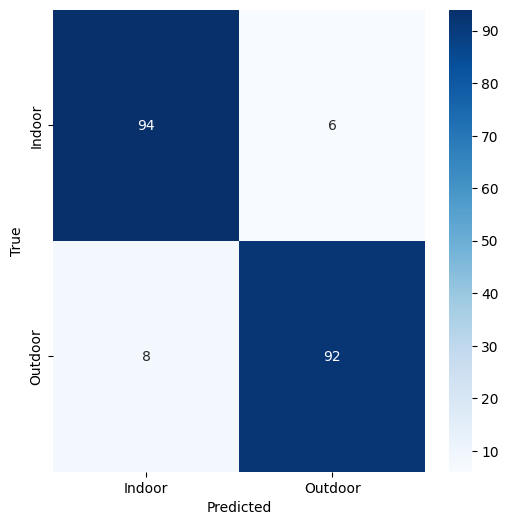


Test Accuracy: 0.9300
Best Validation Accuracy: 0.9280


In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score,roc_curve, auc, precision_recall_curve,average_precision_score
import pandas as pd
import numpy as np

# Load best model
checkpoint = torch.load('best_cnn_model_full.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
best_hyper_params = checkpoint['hyperparameters']
best_val_acc = checkpoint['val_accuracy']
test_loader = DataLoader(test_dataset, batch_size=best_hyper_params['batch_size'], shuffle=False)

all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        probs = torch.sigmoid(outputs)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
class_report=classification_report(all_labels, all_preds, target_names=['Indoor', 'Outdoor'],output_dict=True)
report_df = pd.DataFrame(class_report).transpose()
print(report_df.to_string(index=True))
results = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score"],
    "Score": [accuracy, precision, recall, f1]
}
df_metrics = pd.DataFrame(results)
conf_matrix = confusion_matrix(all_labels, all_preds)
with open("cnn_model.txt", "w") as file:
    file.write("\nMetrics:\n")
    df_metrics.to_string(file, index=False)
    file.write("\nClassification Report:\n")
    file.write("\n")
    file.write(report_df.to_string(index=True))
    file.write("Confusion Matrix:\n")
    file.write(str(conf_matrix) + "\n")
    file.write("\nBest Hyperparameters:\n")
    file.write(str(best_params) + "\n")

# Confusion Matrix
plt.figure(figsize=(6,6))
sns.heatmap(confusion_matrix(all_labels, all_preds),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['Indoor', 'Outdoor'],
            yticklabels=['Indoor', 'Outdoor'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(f"\nTest Accuracy: {accuracy:.4f}")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")

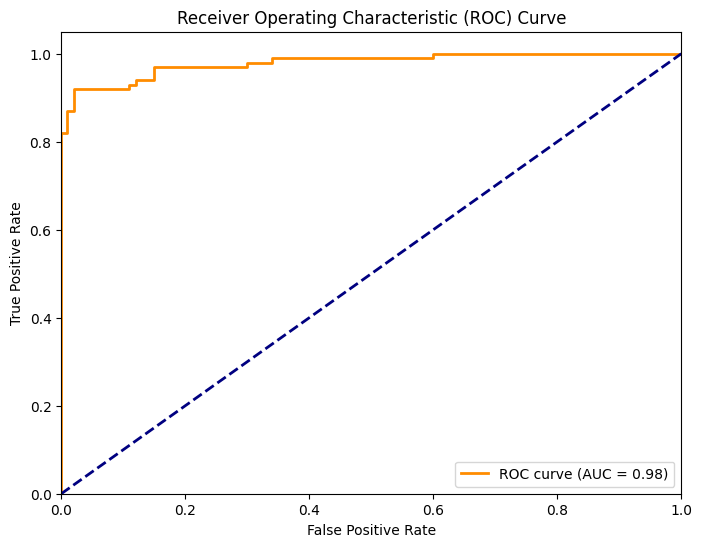

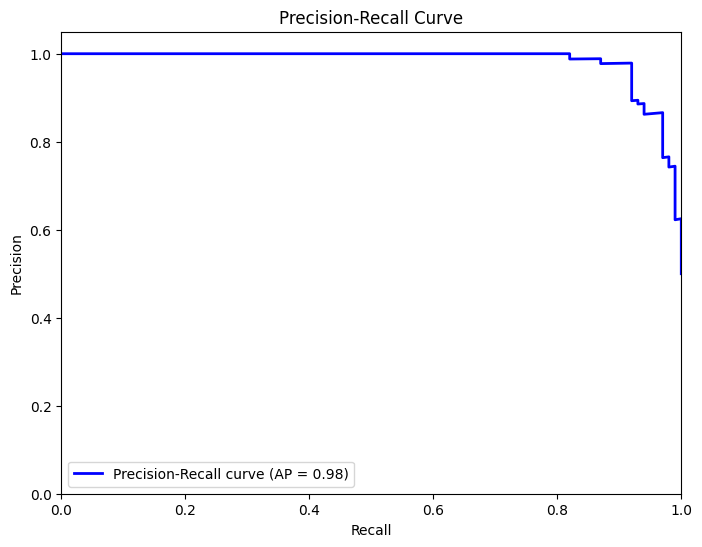

In [23]:
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)
positive_class_probs = all_probs[:, 1]
fpr, tpr, thresholds = roc_curve(all_labels, positive_class_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png')
plt.show()

# 2. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(all_labels, positive_class_probs)
average_precision = average_precision_score(all_labels, positive_class_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2,
         label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.savefig('precision_recall_curve.png')
plt.show()

In [20]:
def predict_image(image_path):
    img = Image.open(image_path).convert('RGB')
    img = test_transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img)
        _, pred = torch.max(output, 1)
        return 'Indoor' if pred.item() == 0 else 'Outdoor'

print(predict_image('indoor1.jpeg'))
print(predict_image('indoor2.jpeg'))
print(predict_image('outdoor1.jpeg'))

Indoor
Indoor
Outdoor


In [24]:
import re

def extract_xgb_metrics(file_path):
    with open(file_path, 'r') as file:
        text = file.read()
    accuracy_match = re.search(r'Accuracy:\s*([0-9.]+)', text)
    precision_match = re.search(r'Precision:\s*([0-9.]+)', text)
    recall_match = re.search(r'Recall:\s*([0-9.]+)', text)
    f1_score_match = re.search(r'F1 Score:\s*([0-9.]+)', text)
    metrics = {
        'Accuracy': accuracy_match.group(1) if accuracy_match else None,
        'Precision': precision_match.group(1) if precision_match else None,
        'Recall': recall_match.group(1) if recall_match else None,
        'F1-Score': f1_score_match.group(1) if f1_score_match else None
    }
    return metrics

def extract_metrics_from_file(file_path):
    with open(file_path, 'r') as file:
        text = file.read()

    accuracy_match = re.search(r'Accuracy\s+([0-9.]+)', text)
    precision_match = re.search(r'Precision\s+([0-9.]+)', text)
    recall_match = re.search(r'Recall\s+([0-9.]+)', text)
    f1_score_match = re.search(r'F1-Score\s+([0-9.]+)', text)
    metrics = {
        'Accuracy': accuracy_match.group(1) if accuracy_match else None,
        'Precision': precision_match.group(1) if precision_match else None,
        'Recall': recall_match.group(1) if recall_match else None,
        'F1-Score': f1_score_match.group(1) if f1_score_match else None
    }
    return metrics

file_path1 = 'adaboost.txt'
metrics1 = extract_metrics_from_file(file_path1)
file_path2 = 'decision_tree_results.txt'
metrics2 = extract_metrics_from_file(file_path2)
file_path3 = 'random_forest_results.txt'
metrics3 = extract_metrics_from_file(file_path3)
file_path4 = 'semisupervised_decision_tree.txt'
metrics4 = extract_metrics_from_file(file_path4)
file_path5 = 'cnn_model.txt'
metrics5 = extract_metrics_from_file(file_path5)

# Print the extracted metrics
print("Metrics from adaboost_results.txt:")
for key, value in metrics1.items():
    print(f'{key}: {value}')
print("\nMetrics from decision_tree_results.txt:")
for key, value in metrics2.items():
    print(f'{key}: {value}')
print("\nMetrics from random_forest_results.txt:")
for key, value in metrics3.items():
    print(f'{key}: {value}')
print("\nMetrics from semisupervised_decision_tree.txt:")
for key, value in metrics4.items():
    print(f'{key}: {value}')
print("\nMetrics from cnn_model.txt:")
for key, value in metrics5.items():
    print(f'{key}: {value}')



Metrics from adaboost_results.txt:
Accuracy: 0.853500
Precision: 0.867846
Recall: 0.834000
F1-Score: 0.850586

Metrics from decision_tree_results.txt:
Accuracy: 0.815000
Precision: 0.846154
Recall: 0.770000
F1-Score: 0.806283

Metrics from random_forest_results.txt:
Accuracy: 0.875000
Precision: 0.894737
Recall: 0.850000
F1-Score: 0.871795

Metrics from semisupervised_decision_tree.txt:
Accuracy: 0.790000
Precision: 0.802083
Recall: 0.770000
F1-Score: 0.785714

Metrics from cnn_model.txt:
Accuracy: 0.930000
Precision: 0.930172
Recall: 0.930000
F1-Score: 0.929993


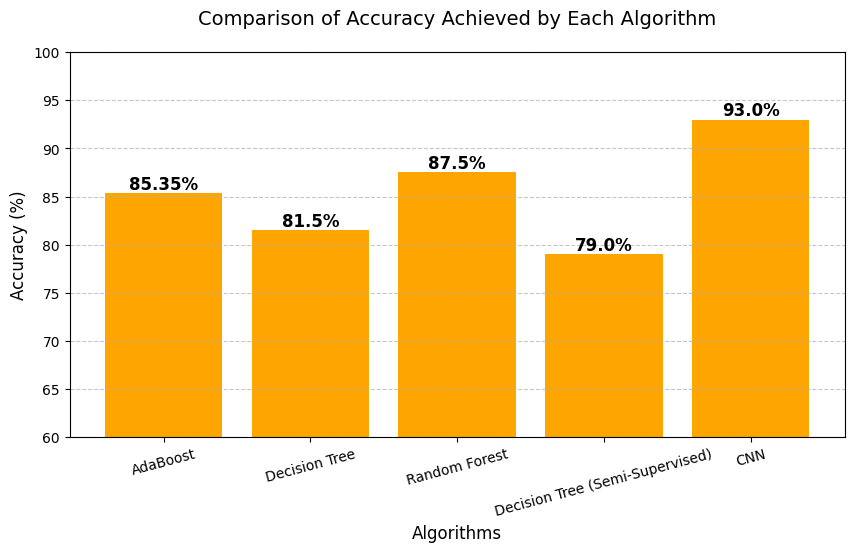

In [35]:
import matplotlib.pyplot as plt

models = ["AdaBoost", "Decision Tree", "Random Forest", "Decision Tree (Semi-Supervised)", "CNN"]
metrics = [metrics1, metrics2, metrics3, metrics4, metrics5]
accuracy_values = [round(float(m["Accuracy"]) * 100, 3) for m in metrics]
colors = 'orange'
plt.figure(figsize=(10, 5))
bars = plt.bar(models, accuracy_values, color=colors)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height()}%',
             ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.xlabel("Algorithms", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)
plt.title("Comparison of Accuracy Achieved by Each Algorithm", fontsize=14,pad=20)
plt.ylim(60, 100)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


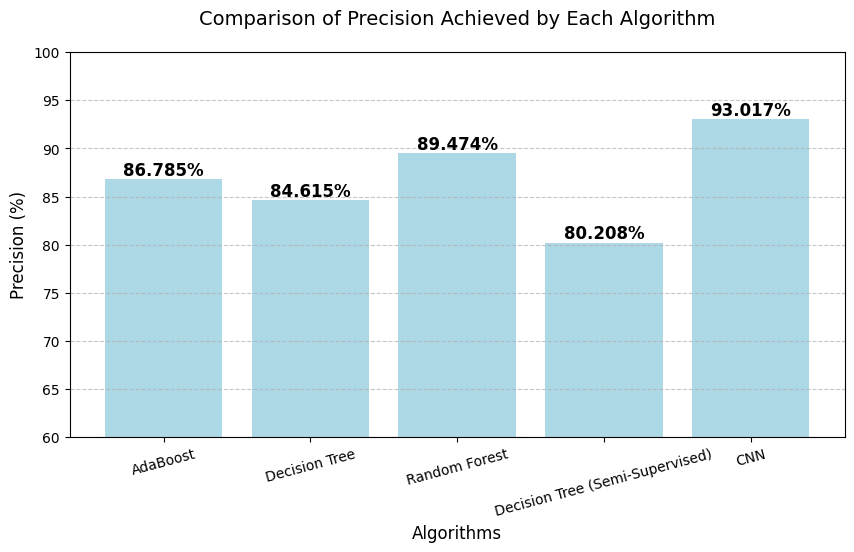

In [36]:
import matplotlib.pyplot as plt

models = ["AdaBoost", "Decision Tree", "Random Forest", "Decision Tree (Semi-Supervised)", "CNN"]
metrics = [metrics1, metrics2, metrics3, metrics4, metrics5]
precision_values = [round(float(m["Precision"]) * 100, 3) for m in metrics]
colors = 'lightblue'
plt.figure(figsize=(10, 5))
bars = plt.bar(models, precision_values, color=colors)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height()}%',
             ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.xlabel("Algorithms", fontsize=12)
plt.ylabel("Precision (%)", fontsize=12)
plt.title("Comparison of Precision Achieved by Each Algorithm", fontsize=14,pad=20)
plt.ylim(60, 100)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


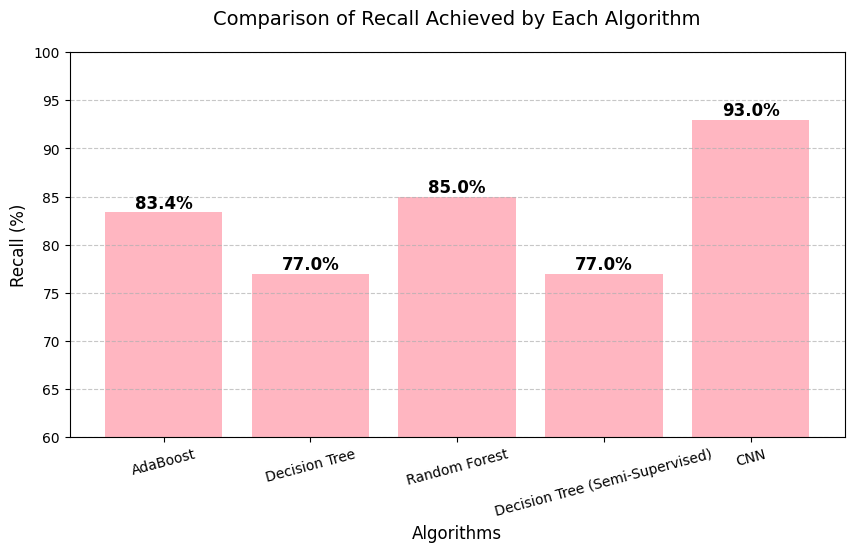

In [37]:
import matplotlib.pyplot as plt

models = ["AdaBoost", "Decision Tree", "Random Forest", "Decision Tree (Semi-Supervised)","CNN"]
metrics = [metrics1, metrics2, metrics3, metrics4, metrics5]
recall_values = [round(float(m["Recall"]) * 100, 3) for m in metrics]
colors = 'lightpink'
plt.figure(figsize=(10, 5))
bars = plt.bar(models, recall_values, color=colors)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height()}%',
             ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.xlabel("Algorithms", fontsize=12)
plt.ylabel("Recall (%)", fontsize=12)
plt.title("Comparison of Recall Achieved by Each Algorithm", fontsize=14,pad=20)
plt.ylim(60, 100)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


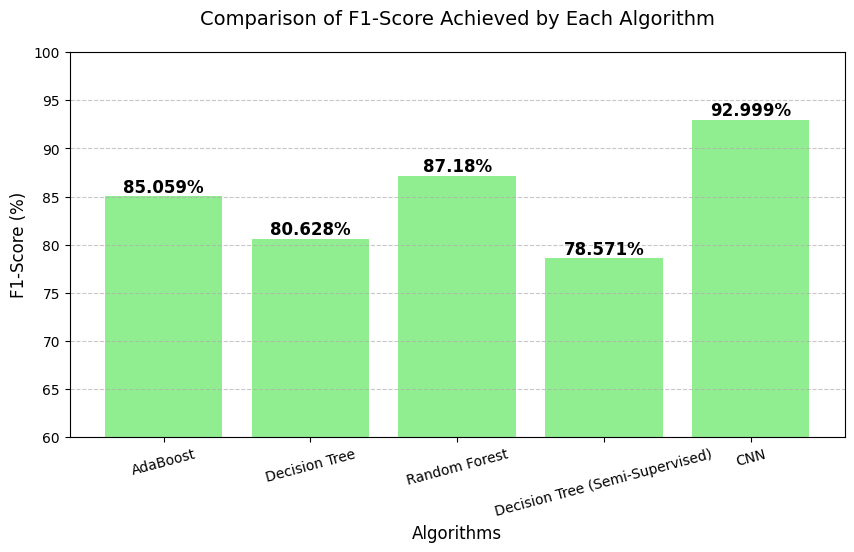

In [38]:
import matplotlib.pyplot as plt

models = ["AdaBoost", "Decision Tree", "Random Forest", "Decision Tree (Semi-Supervised)","CNN"]
metrics = [metrics1, metrics2, metrics3, metrics4, metrics5]
f1_score_values = [round(float(m["F1-Score"]) * 100, 3) for m in metrics]
colors = 'lightgreen'
plt.figure(figsize=(10, 5))
bars = plt.bar(models, f1_score_values, color=colors)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height()}%',
             ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.xlabel("Algorithms", fontsize=12)
plt.ylabel("F1-Score (%)", fontsize=12)
plt.title("Comparison of F1-Score Achieved by Each Algorithm", fontsize=14,pad=20)
plt.ylim(60, 100)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
